### Libraries, functions etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import expit

import sys
sys.path.insert(1, '../')

import measures
from model import LogReg
from preprocessing import Preprocessor
import experiments

### Loading data

In [3]:
etherneum_df=pd.read_csv('../data/transaction_dataset.csv')

y_eth=etherneum_df['FLAG']
to_drop=['Unnamed: 0','Index','Address','FLAG']
X_eth=etherneum_df.drop(columns=to_drop)

prep_eth = Preprocessor()

Basic data info:

In [4]:
etherneum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                          9841

The dataset contains 50 columns out of which about 45 can be valid variables during modelling. About half of them contain missing values. We are going to deal with them by filling with the most frequent values.


In [16]:
X_eth_train, X_eth_test, y_eth_train, y_eth_test = prep_eth.train_test_split(X_eth, y_eth)

The target classes are imbalanced - data balancing may be needed:

In [17]:
y_eth_train.mean()

0.22140921409214093

In [18]:
for col in X_eth_train.columns:
    m_f_v = X_eth_train[col].value_counts().index[0]
    #train set
    X_eth_train[col]=X_eth_train[col].fillna(m_f_v)
    #test set
    X_eth_test[col]=X_eth_test[col].fillna(m_f_v)


In [52]:
X_train=X_eth_train.copy()
X_test=X_eth_test.copy()
y_train=y_eth_train.copy()
y_test=y_eth_test.copy()

#Coll. removal befor OHE -> because of curse of dimensionality, VIF looong execution
X_train = prep_eth.remove_multicollinearity_fit_transform(X_train, vif_thresh=5)
X_test = prep_eth.remove_multicollinearity_transform(X_test)

X_train = prep_eth.one_hot_encoding_fit_transform(X_train)
X_test = prep_eth.one_hot_encoding_transform(X_test)

#Removing constant columns
constant_columns = X_train.loc[:, X_train.std()==0].columns
X_train.drop(constant_columns, axis=1, inplace=True)
X_test.drop(constant_columns, axis=1, inplace=True)


X_train_rc=X_train.to_numpy()
y_train_rc=y_train.to_numpy()
X_test_rc=X_test.to_numpy()
y_test_rc=y_test.to_numpy()

37 numerical features left in dataset  2  categorical


#### 1. Convergence analysis: check how the value of log-likelihood function depends on the number of iterations for 4 above algorithms.

In [54]:
lr=0.01
n_epochs=1000

lr_models = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=32),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=0.01, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

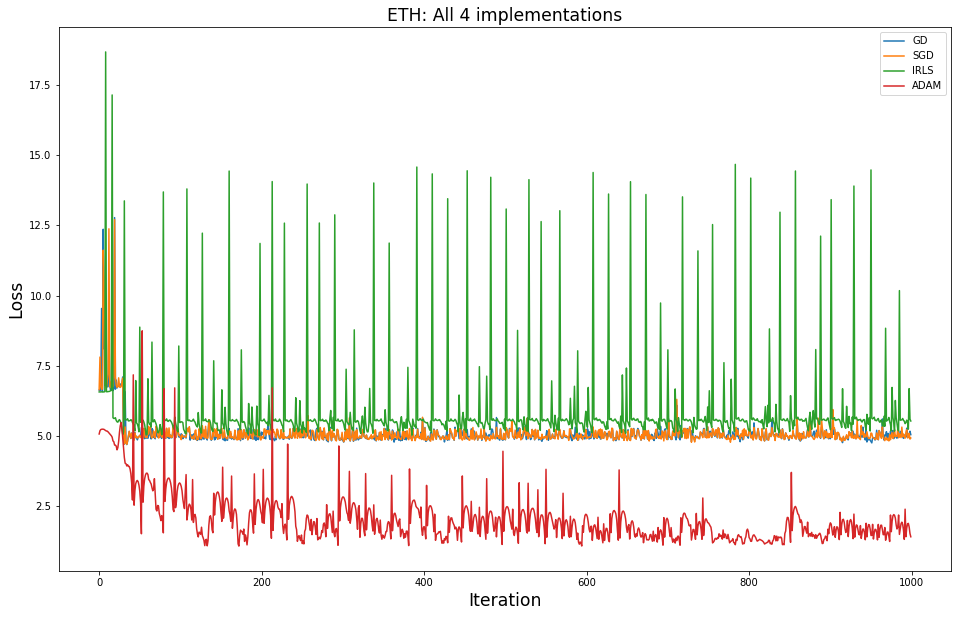

In [55]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models.items():
    model.train(X_train_rc, y_train_rc)
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('ETH: All 4 implementations',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('ETH_conv_01.svg')
plt.show()

#### (1b) Impact of target balancing & data scaling

Only target balancing:

In [60]:
X_train_rc_balanced, y_train_rc_balanced = prep_eth.class_balancing(pd.DataFrame(X_train_rc, index = y_train.index),y_train)


Training dataset has now  11492 obervations. 50.0  percent is in positive group.


In [61]:
lr=0.01
n_epochs=1000

lr_models_2 = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=32),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=0.01, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

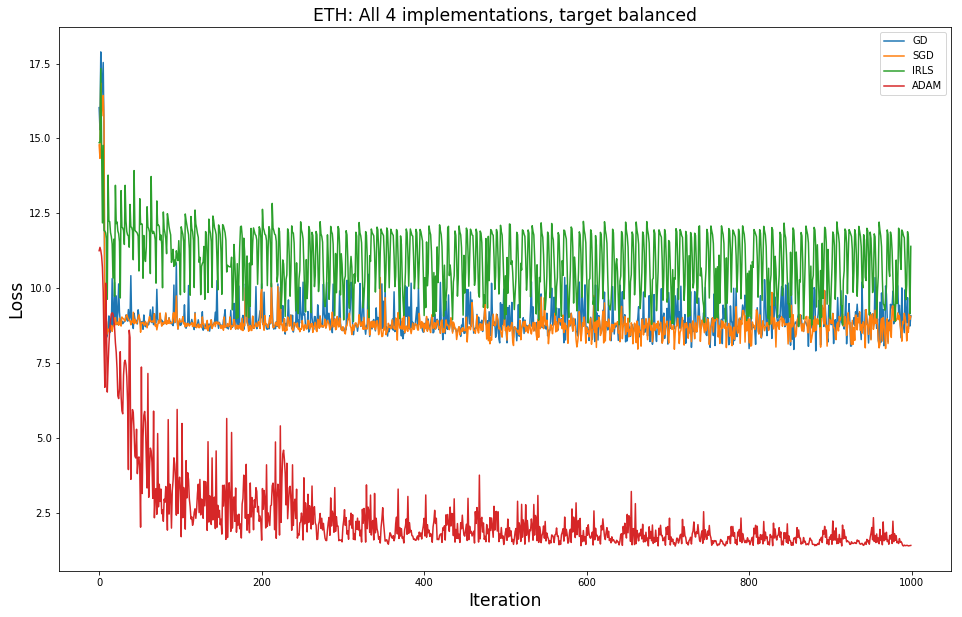

In [64]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models_2.items():
    model.train(X_train_rc_balanced.to_numpy(), y_train_rc_balanced.to_numpy())
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('ETH: All 4 implementations, target balanced',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('ETH_conv_02.svg')
plt.show()

Target balancing & data scaling

In [65]:
s = StandardScaler()
X_train_scaled = s.fit_transform(X_train_rc_balanced)
X_test_scaled = s.transform(X_test)

In [66]:
lr_models_3 = {
     'GD': LogReg(optimization='Gradient Descent', learning_rate=lr, epochs=n_epochs, batch_size=32),
     'SGD': LogReg(optimization='Stochastic Gradient Descent', learning_rate=lr, epochs=n_epochs),
     'IRLS': LogReg(optimization='Iterative Reweighted Least Squares', epochs=n_epochs),
     'ADAM': LogReg(optimization='Adaptive Moment Estimation', epochs=n_epochs, learning_rate=0.01, beta_1=0.9,
                    beta_2=0.99, epsilon=1e-8)
 }

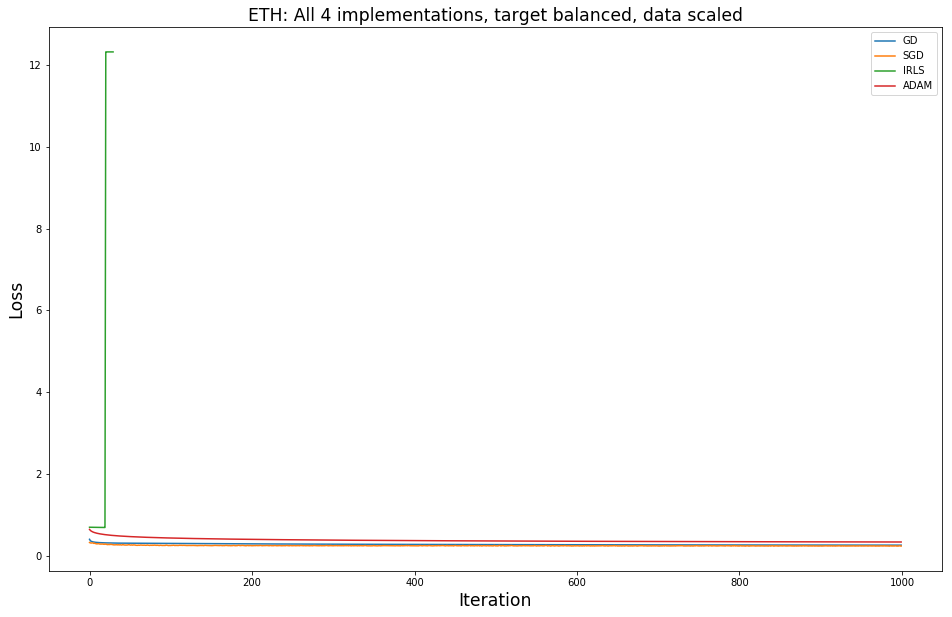

In [76]:
plt.figure(figsize=(16, 10))
losses={}
for model_name, model in lr_models_3.items():
    model.train(X_train_scaled, y_train_rc_balanced.to_numpy())
    losses[model_name]=model.get_optimizer_training_losses()
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('ETH: All 4 implementations, target balanced, data scaled',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('ETH_conv_03.svg')
plt.show()

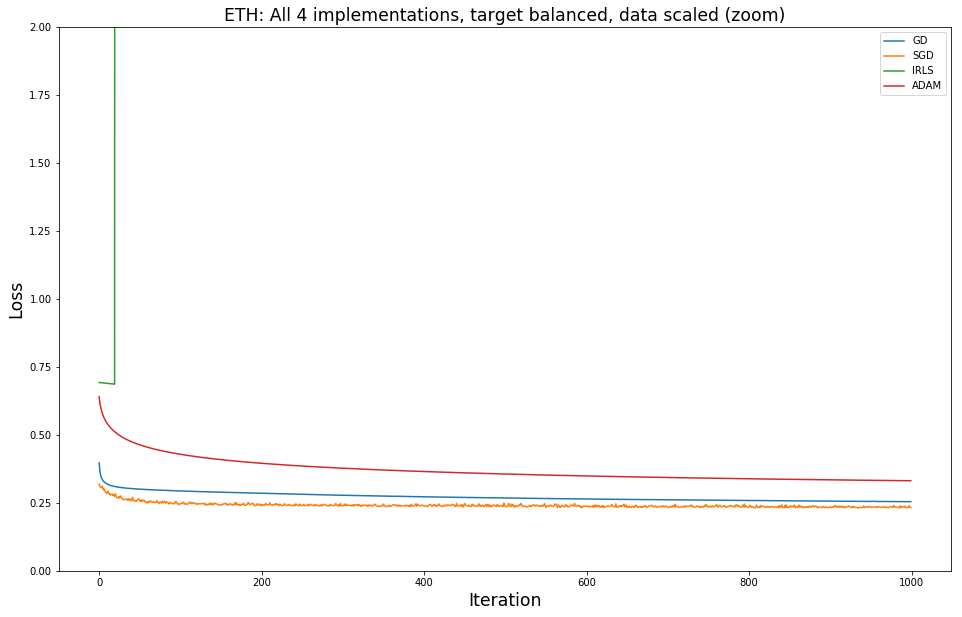

In [77]:
plt.figure(figsize=(16, 10))
for model_name, model in lr_models_3.items():
    plt.plot(range(len(losses[model_name])), losses[model_name], label=model_name)
plt.title('ETH: All 4 implementations, target balanced, data scaled (zoom)',fontsize='xx-large')
plt.xlabel("Iteration",fontsize='xx-large')
plt.ylabel("Loss",fontsize='xx-large')
plt.legend()
plt.savefig('ETH_conv_03_bis.svg')
plt.show()

Comparison of algorithms afficiency:

In [74]:
comp_df = pd.DataFrame(columns=['algorithm', 'transform', 'f_measure'])
for model_name in lr_models:
    f_no_scal = measures.f_measure(lr_models[model_name].predict(X_test), y_test)
    f_balanced = measures.f_measure(lr_models_2[model_name].predict(X_test), y_test)
    f_scaled = measures.f_measure(lr_models_3[model_name].predict(X_test_scaled), y_test)
    comp_df = pd.concat((comp_df, pd.DataFrame({'algorithm': [model_name]*3,
                                                'transform': ['None', 'Balancing', 'Balancing & scaling'],
                                                'f_measure': [f_no_scal, f_balanced, f_scaled]})),
                        ignore_index=True)

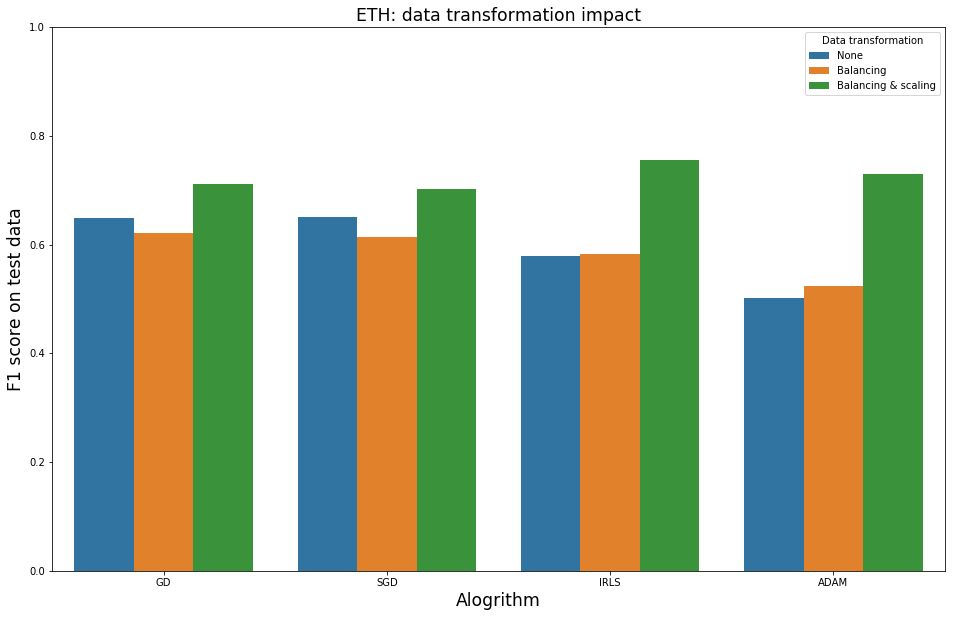

In [75]:
plt.figure(figsize=(16, 10))
sns.barplot(x='algorithm', y='f_measure', data=comp_df, hue='transform')
plt.legend(loc=1, title='Data transformation')
plt.ylim(0, 1)
plt.title('ETH: data transformation impact', fontsize='xx-large')
plt.xlabel('Alogrithm', fontsize='xx-large')
plt.ylabel('F1 score on test data', fontsize='xx-large')
plt.savefig('ETH_transformation_impact.svg')
plt.show()

Significant imporvement visible on both values of loss function and classification metrics on test data.

In [82]:
#Names unification:
X_train_scaled_balanced = X_train_scaled.copy()
y_train_scaled_balanced = y_train_rc_balanced.copy().to_numpy()
X_test_scaled_balanced = X_test_scaled.copy()
y_test_scaled_balanced = y_test.copy()

#### 2. Check how the value of learning rate and other parameters affect the results.

In [83]:
tested_l_rates=np.linspace(start=0.2,stop=1e-5,num=6)
tested_algorithms={'GD': 'Gradient Descent','SGD':'Stochastic Gradient Descent','ADAM':'Adaptive Moment Estimation'}

res_test_learning_rates=experiments.test_learning_rates(X_train=X_train_scaled_balanced,
                                                        y_train=y_train_scaled_balanced,
                                                        X_test=X_test_scaled_balanced,
                                                        y_test=y_test_scaled_balanced,
                                                        l_rates=tested_l_rates,
                                                        algorithms=tested_algorithms,
                                                        n_epochs=50)

res_test_learning_rates

,learning_rate,method,accuracy,recall,precision,F_measure
0,0.200000,GD,0.832,0.934,0.574,0.711
1,0.200000,SGD,0.823,0.905,0.562,0.693
2,0.200000,ADAM,0.850,0.850,0.617,0.715
3,0.160002,GD,0.835,0.934,0.580,0.715
4,0.160002,SGD,0.824,0.921,0.562,0.698
5,0.160002,ADAM,0.898,0.615,0.889,0.727
6,0.120004,GD,0.835,0.930,0.580,0.715
7,0.120004,SGD,0.825,0.906,0.566,0.697
8,0.120004,ADAM,0.898,0.615,0.891,0.727
9,0.080006,GD,0.851,0.873,0.616,0.722


In [85]:
res_test_learning_rates.sort_values(['method', 'accuracy', 'F_measure'], ascending=[True, False, False])\
                       .groupby('method').head(2)

,learning_rate,method,accuracy,recall,precision,F_measure
14,0.040008,ADAM,0.900,0.615,0.901,0.731
5,0.160002,ADAM,0.898,0.615,0.889,0.727
15,0.000010,GD,0.913,0.613,0.988,0.757
12,0.040008,GD,0.854,0.839,0.628,0.718
16,0.000010,SGD,0.911,0.618,0.971,0.756
10,0.080006,SGD,0.828,0.901,0.570,0.698


In [84]:
res_test_learning_rates[res_test_learning_rates['method']=='ADAM'].sort_values(by=['accuracy','F_measure','recall','precision'],ascending=False).head(3)

,learning_rate,method,accuracy,recall,precision,F_measure
14,0.040008,ADAM,0.900,0.615,0.901,0.731
8,0.120004,ADAM,0.898,0.615,0.891,0.727
5,0.160002,ADAM,0.898,0.615,0.889,0.727


In [ ]:
tested_betas_1=np.linspace(start=0.75,stop=.97,num=12)
tested_betas_2=np.linspace(start=0.90,stop=0.99,num=10)
learning_rates = [0.04, 0.12, 0.16]

res_test_betas=experiments.test_betas(X_train=X_train.to_numpy(),
                                      y_train=y_train.to_numpy(),
                                      X_test=X_test.to_numpy(),
                                      y_test=y_test.to_numpy(),
                                      tested_betas1=tested_betas_1,
                                      tested_betas2=tested_betas_2,
                                      learning_rates=learning_rates,
                                     n_epochs=50)

res_test_betas.sort_values(by=['accuracy','F_measure','recall','precision'],ascending=False).head(10)

#### 4. Compare the classification performance of logistic regression (try all 4 methods: IWLS, GD, SGD and ADAM) and 3 popular classification methods: LDA, QDA and KNN. Use the performance measures implemented in Part 2 and datasets prepared in Part 1. The performance measures should be calculated on test set. If the given algorithm does not converge, within 1000 iterations, stop the algorithm and use the solutions from the last iteration.

In [ ]:
n_epochs=1000

batch_size_gd=0.1
lr_gd=0.04

lr_sgd=0.1

lr_adam=0.02
beta1_adam=0.95
beta2_adam=0.96

models = {
    'GD': LogReg(optimization='Gradient Descent',
                 learning_rate=lr_gd,
                 epochs=n_epochs,
                 batch_size=batch_size_gd),
    'SGD': LogReg(optimization='Stochastic Gradient Descent',
                  learning_rate=lr_sgd,
                  epochs=n_epochs),
    'IRLS': LogReg(optimization='Iterative Reweighted Least Squares',
                   epochs=n_epochs),
    'ADAM': LogReg(optimization='Adaptive Moment Estimation',
                   epochs=n_epochs,
                   learning_rate=lr_adam,
                   beta_1=beta1_adam,
                   beta_2=beta2_adam,
                   epsilon=1e-8),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'LR': LogisticRegression(max_iter=n_epochs),
    'kNN': KNeighborsClassifier()
}


In [ ]:
res_final=experiments.final_comparisson(X_train=X_train,
                                        y_train=y_train,
                                        X_test=X_test,
                                        y_test=y_test,
                                        models=models)

res_final.sort_values(by=['accuracy','f_measure','recall','precision'],ascending=False)